# LIDC-IDRI dataset
## Pruebas del código

In [66]:
import sys
import os
from pathlib import Path
import glob
from configparser import ConfigParser
import pandas as pd
import numpy as np
import warnings
import pylidc as pl
from tqdm import tqdm
from statistics import median_high

from utils import is_dir_path,segment_lung
from pylidc.utils import consensus
from PIL import Image

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 50

warnings.filterwarnings(action='ignore')

# Read the configuration file generated from config_file_create.py
parser = ConfigParser()
parser.read('lung.conf')

#Get Directory setting
DICOM_DIR = is_dir_path(parser.get('prepare_dataset','LIDC_DICOM_PATH'))
MASK_DIR = is_dir_path(parser.get('prepare_dataset','MASK_PATH'))
IMAGE_DIR = is_dir_path(parser.get('prepare_dataset','IMAGE_PATH'))
CLEAN_DIR_IMAGE = is_dir_path(parser.get('prepare_dataset','CLEAN_PATH_IMAGE'))
CLEAN_DIR_MASK = is_dir_path(parser.get('prepare_dataset','CLEAN_PATH_MASK'))
META_DIR = is_dir_path(parser.get('prepare_dataset','META_PATH'))

In [67]:
LIDC_IDRI_list= [f for f in os.listdir(DICOM_DIR) if not f.startswith('.')]
LIDC_IDRI_list.sort()

In [90]:
from matplotlib import pyplot as plt

confidence_level = parser.getfloat('pylidc','confidence_level') # confidence level of consensus
padding = parser.getint('pylidc','padding_size')
padding=[(padding,padding),(padding,padding),(0,0)]
mask_threshold = parser.getint('prepare_dataset','Mask_Threshold')
# This is to name each image and mask
prefix = [str(x).zfill(3) for x in range(1000)]

FILES_DIR="../files"

for patient in tqdm(LIDC_IDRI_list):
    pid = patient # LIDC-IDRI-0001, etc
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
    nodules_annotation = scan.cluster_annotations()
    vol = scan.to_volume()
    print("Patient ID: {} Dicom Shape: {} Number of Annotated Nodules: {}".format(pid,
            vol.shape,len(nodules_annotation)))
    patient_image_dir = IMAGE_DIR+"/"+pid
    patient_mask_dir = MASK_DIR+"/"+pid
    files_dir=FILES_DIR+"/"+pid
    # Create directory
    if not os.path.exists(files_dir):
            os.makedirs(files_dir)
    if len(nodules_annotation) > 0:
        # Patients with nodules
        for nodule_idx, nodule in enumerate(nodules_annotation):
                mask, cbbox, masks = consensus(nodule,confidence_level,padding) # aqui hay algo mal
                for nodule_slice in range(mask.shape[2]):
                        # This second for loop iterates over each single nodule.
                        # There are some mask sizes that are too small. These may hinder training.
                        if np.sum(mask[:,:,nodule_slice]) <= mask_threshold:
                                continue
                        nodule_name = "{}_NI{}_slice{}".format(pid[-4:],prefix[nodule_idx],prefix[nodule_slice])
                        mask_name = "{}_MA{}_slice{}".format(pid[-4:],prefix[nodule_idx],prefix[nodule_slice])
                        lung_segmented=np.load(patient_image_dir+"/"+nodule_name+'.npy')
                        loaded_mask=np.load(patient_mask_dir+"/"+mask_name+'.npy')
                        f, ax = plt.subplots(1,2,figsize=(15,15))
                        ax[0].imshow(lung_segmented)
                        ax[1].imshow(loaded_mask)
                        ax[0].set_title("Original segmented image")
                        ax[1].set_title("Original mask")
                        plt.savefig(files_dir+"/"+'Visualization'+nodule_name+'.png',dpi=300)

Loading dicom files ... This may take a moment.
Patient ID: LIDC-IDRI-0001 Dicom Shape: (512, 512, 133) Number of Annotated Nodules: 1


Loading dicom files ... This may take a moment.
Patient ID: LIDC-IDRI-0002 Dicom Shape: (512, 512, 261) Number of Annotated Nodules: 1


Loading dicom files ... This may take a moment.


: 

: 

Loading dicom files ... This may take a moment.


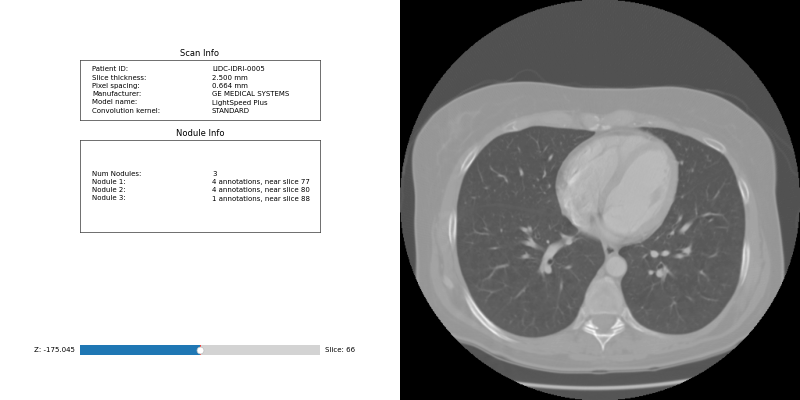

In [4]:
%matplotlib widget
annot=scan.visualize(annotation_groups=nodules_annotation)

Loading dicom files ... This may take a moment.


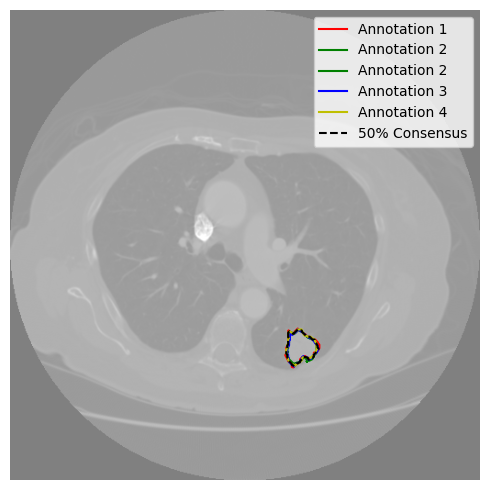

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as manim
from skimage.measure import find_contours

import pylidc as pl
from pylidc.utils import consensus


# Query for a scan, and convert it to an array volume.
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == "LIDC-IDRI-0001").first()
vol = scan.to_volume()

# Cluster the annotations for the scan, and grab one.
nods = scan.cluster_annotations()
anns = nods[0]

# Perform a consensus consolidation and 50% agreement level.
# We pad the slices to add context for viewing.
cmask,cbbox,masks = consensus(anns, clevel=0.5,
                              pad=[(512,512), (512,512), (0,0)])

# Get the central slice of the computed bounding box.
k = int(0.5*(cbbox[2].stop - cbbox[2].start))

# Set up the plot.
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(vol[cbbox][:,:,k], cmap=plt.cm.gray, alpha=0.5)

# Plot the annotation contours for the kth slice.
colors = ['r', 'g', 'b', 'y']
for j in range(len(masks)):
    for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
        label = "Annotation %d" % (j+1)
        plt.plot(c[:,1], c[:,0], colors[j], label=label)

# Plot the 50% consensus contour for the kth slice.
for c in find_contours(cmask[:,:,k].astype(float), 0.5):
    plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')

ax.axis('off')
ax.legend()
plt.tight_layout()
#plt.savefig("../images/consensus.png", bbox_inches="tight")
plt.show()